In [41]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl

In [2]:
aisles_df = pl.read_csv("../data/aisles.csv")
departments_df = pl.read_csv("../data/departments.csv")
order_prior_df = pl.read_csv("../data/order_products__prior.csv")
order_train_df = pl.read_csv("../data/order_products__train.csv")
orders_df = pl.read_csv("../data/orders.csv")
products_df = pl.read_csv("../data/products.csv")

In [3]:
data = pl.read_csv("../data/feature_engineered_data.csv")

### Creating Training and Testing Datasets

In [4]:
orders_df = orders_df.with_columns(
    pl.when(pl.col("eval_set") == "prior").then(0)
    .when(pl.col("eval_set") == "train").then(1)
    .when(pl.col("eval_set") == "test").then(2)
    .otherwise(pl.col("eval_set")).cast(pl.Int32).alias("eval_set")
)

In [5]:
# keeping only the train and test set from the order df

orders_future = orders_df.filter(
  (pl.col("eval_set") == 1) | (pl.col("eval_set") == 2)
).select(["user_id", "eval_set", "order_id"])

In [6]:
# merging the order_future with data
data = data.join(orders_future, on="user_id", how="left")

In [7]:
# preparing the training dataset

data_train = data.filter(
  pl.col("eval_set") == 1
)

In [8]:
# merging the information contained in the order_products__train.csv into data_train

data_train = data_train.join(order_train_df.select(["product_id", "order_id", "reordered"]), on=["product_id", "order_id"], how="left")

In [9]:
data_train = data_train.with_columns(
    pl.col("reordered").fill_null(strategy="zero").alias("reordered")
)

In [10]:
data_train = data_train.drop(["eval_set", "order_id"])

In [11]:
data_train.head()

user_id,product_id,uxp_times_bought,uxp_reorder_ratio,uxp_last_five,uxp_ratio_last_five,u_num_of_orders,u_avg_prd,dow_u_most_orders,hod_u_most_orders,u_reorder_ratio,average_days_between_orders,u_total_items_bought,p_num_of_times,p_reorder_ratio,p_avg_cart_position,reordered
i64,i64,i64,f64,i64,f64,i64,f64,i64,i64,f64,f64,i64,i64,f64,f64,i64
1,196,10,1.0,5,1.0,10,5.9,4,7,0.694915,18.542373,59,35791,0.77648,3.721774,1
1,10258,9,1.0,5,1.0,10,5.9,4,7,0.694915,18.542373,59,1946,0.713772,4.277492,1
1,10326,1,0.166667,0,0.0,10,5.9,4,7,0.694915,18.542373,59,5526,0.652009,4.191097,0
1,12427,10,1.0,5,1.0,10,5.9,4,7,0.694915,18.542373,59,6476,0.740735,4.760037,0
1,13032,3,0.333333,2,0.4,10,5.9,4,7,0.694915,18.542373,59,3751,0.657158,5.622767,1


In [12]:
data_test = data.filter(
  pl.col("eval_set") == 2
)

In [13]:
data_test = data_test.drop(["eval_set", "order_id"])

In [14]:
print(f" The shape of the train data set is {data_train.shape} and the test data set is {data_test.shape}")

 The shape of the train data set is (8474661, 17) and the test data set is (4833292, 16)


In [15]:
# adding aisle and department data

data_train = data_train.join(products_df.select(['product_id', 'aisle_id', 'department_id']), on="product_id", how="left")
data_test = data_test.join(products_df.select(['product_id', 'aisle_id', 'department_id']), on="product_id", how="left")

In [16]:
data_train = data_train.sort(by=["user_id", "product_id"])
data_test = data_test.sort(by=["user_id", "product_id"])

In [17]:
# mean encoding categorical variables

columns_mean = ["aisle_id", "department_id"]

for col in columns_mean:
  mean = (
    data_train
    .group_by(col)
    .agg(pl.col("reordered").mean())
    .rename({'reordered': f'{col}_mean'})
  )

  data_train = data_train.join(mean, on=col, how='left')
  data_test = data_test.join(mean, on=col, how='left')
  
  # Replace original column with mean values
  data_train = data_train.with_columns(pl.col(f'{col}_mean').alias(col))
  data_test = data_test.with_columns(pl.col(f'{col}_mean').alias(col))
  
  # Drop temporary mean column
  data_train = data_train.drop(f'{col}_mean')
  data_test = data_test.drop(f'{col}_mean')

### Model Building

In [18]:
# import ml packages

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import xgboost as xgb

In [19]:
X = data_train.drop(['reordered', 'uxp_ratio_last_five'])
y = data_train.select(["reordered"])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [21]:
parameters = {
    'max_depth' : 5,
    'colsample_bytree' : 0.4,
    'subsample' : 0.8,
    'objective': 'binary:logistic'
}

In [22]:
xgb = xgb.XGBClassifier(**parameters)

In [23]:
%%time
xgb.fit(X_train, y_train)

CPU times: user 1min 3s, sys: 4.28 s, total: 1min 7s
Wall time: 14.8 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [24]:
y_pred = (xgb.predict_proba(X_test)[:, 1] >= 0.21).astype('int')

print('F1 Score: {}'.format(f1_score(y_pred, y_test)))
print(classification_report(y_pred, y_test))

F1 Score: 0.4328199070441446
              precision    recall  f1-score   support

           0       0.91      0.94      0.93   2208139
           1       0.51      0.38      0.43    334260

    accuracy                           0.87   2542399
   macro avg       0.71      0.66      0.68   2542399
weighted avg       0.86      0.87      0.86   2542399



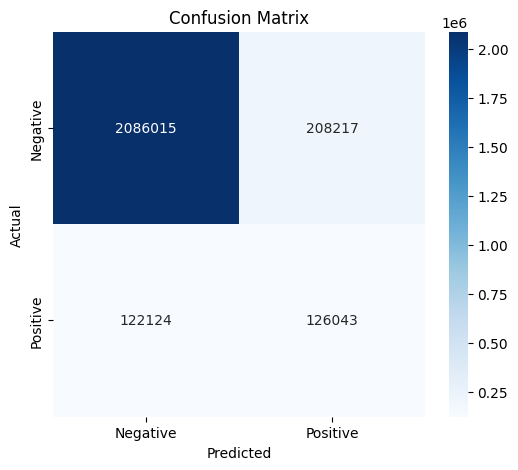

In [25]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

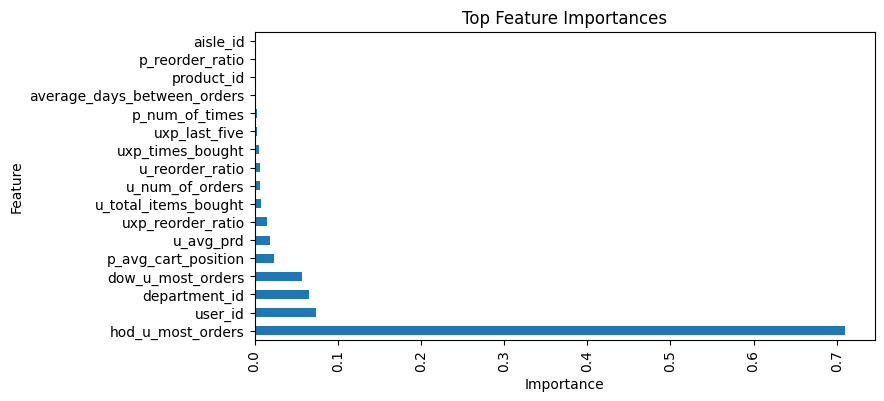

In [26]:
importances = xgb.feature_importances_

columns = pd.Index(data_test.columns)
columns = columns.difference(["uxp_ratio_last_five"])
features = pd.Series(importances, index=columns)
features = features.sort_values(ascending=False)
top_features = features.head(20)

plt.figure(figsize=(8, 4))
top_features.plot(kind='barh')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top Feature Importances')
plt.xticks(rotation=90)
plt.show()


In [27]:
xgb.fit(data_train.drop(['reordered', 'uxp_ratio_last_five']), data_train.select(["reordered"]))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [28]:
y_pred_test = (xgb.predict_proba(data_test.drop('uxp_ratio_last_five'))[:, 1] >= 0.21).astype('int')

In [29]:
data_test = data_test.with_columns(
  pl.Series("prediction", y_pred_test)
)

In [30]:
final = data_test.select(["product_id", "user_id", "prediction"])

In [31]:
order_test = orders_df.filter(
  pl.col("eval_set") == 2
).select(["user_id", "order_id"])

In [32]:
final = final.join(order_test, on="user_id", how="left")

In [33]:
final = final.drop("user_id")

In [34]:
d = {}

for row in final.filter(pl.col("prediction") == 1).rows():
    order_id = row[final.columns.index("order_id")]
    product_id = row[final.columns.index("product_id")]
    
    if order_id in d:
        d[order_id] += ' ' + str(product_id)
    else:
        d[order_id] = str(product_id)


for order in final["order_id"]:
    if order not in d:
        d[order] = 'None'

In [35]:
sub = pl.DataFrame(list(d.items()), schema=["order_id", "products"])


sub.head()

/opt/anaconda3/envs/kaggle/lib/python3.10/functools.py:889: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  return dispatch(args[0].__class__)(*args, **kw)


order_id,products
i64,str
2774568,"""17668 18599 21903 22035 39190 …"
1528013,"""21903 38293"""
1376945,"""8309 13176 14947 27959 28465 3…"
1356845,"""7076 10863 11520 13176 14992 2…"
2161313,"""196 10441 11266 12427 14715 27…"


In [36]:
sub.write_csv('../submissions/submission_xgboost.csv', include_header=True)

### Hyperparameter Tuning using parameter grid

In [37]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [7, 10],
    'colsample_bytree' : [0.4],
    'subsample' : [0.8]
    # 'learning_rate': [0.05, 0.1, 0.2],
    # 'subsample': [0.8, 0.9, 1.0],
    # 'min_child_weight': [1, 3, 5],
    # 'scale_pos_weight': [1, 2, 3]
}

In [38]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(objective='binary:logistic')

In [39]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=3,
                           verbose=2,
                           n_jobs=-1)

In [40]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END colsample_bytree=0.4, max_depth=7, n_estimators=100, subsample=0.8; total time= 1.8min
[CV] END colsample_bytree=0.4, max_depth=7, n_estimators=100, subsample=0.8; total time= 1.9min
[CV] END colsample_bytree=0.4, max_depth=7, n_estimators=100, subsample=0.8; total time= 1.9min
[CV] END colsample_bytree=0.4, max_depth=7, n_estimators=200, subsample=0.8; total time= 3.3min
[CV] END colsample_bytree=0.4, max_depth=7, n_estimators=200, subsample=0.8; total time= 3.3min
[CV] END colsample_bytree=0.4, max_depth=7, n_estimators=200, subsample=0.8; total time= 3.4min
[CV] END colsample_bytree=0.4, max_depth=10, n_estimators=100, subsample=0.8; total time= 2.5min
[CV] END colsample_bytree=0.4, max_depth=10, n_estimators=100, subsample=0.8; total time= 2.4min
[CV] END colsample_bytree=0.4, max_depth=7, n_estimators=300, subsample=0.8; total time= 4.7min
[CV] END colsample_bytree=0.4, max_depth=7, n_estimators=300, subsample=0.

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.4], 'max_depth': [7, 10],
                         'n_estimators': [100, 200, 300], 'subsample': [0.8]},
             scoring='accuracy', verbose=2)

In [42]:
print("Best hyperparameters found: ", grid_search.best_params_)

Best hyperparameters found:  {'colsample_bytree': 0.4, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


In [47]:
best_model = grid_search.best_estimator_
y_pred =(best_model.predict_proba(X_test)[:, 1] >= 0.21).astype('int')

In [48]:
print('F1 Score: {}'.format(f1_score(y_pred, y_test)))
print(classification_report(y_pred, y_test))

F1 Score: 0.4344661524339284
              precision    recall  f1-score   support

           0       0.91      0.95      0.93   2206654
           1       0.51      0.38      0.43    335745

    accuracy                           0.87   2542399
   macro avg       0.71      0.66      0.68   2542399
weighted avg       0.86      0.87      0.86   2542399



In [49]:
grid_search.fit(data_train.drop(['reordered', 'uxp_ratio_last_five']), data_train.select(["reordered"]))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END colsample_bytree=0.4, max_depth=7, n_estimators=100, subsample=0.8; total time= 2.0min
[CV] END colsample_bytree=0.4, max_depth=7, n_estimators=100, subsample=0.8; total time= 2.0min
[CV] END colsample_bytree=0.4, max_depth=7, n_estimators=100, subsample=0.8; total time= 2.1min
[CV] END colsample_bytree=0.4, max_depth=7, n_estimators=200, subsample=0.8; total time= 4.5min
[CV] END colsample_bytree=0.4, max_depth=7, n_estimators=200, subsample=0.8; total time= 4.5min
[CV] END colsample_bytree=0.4, max_depth=7, n_estimators=200, subsample=0.8; total time= 4.5min
[CV] END colsample_bytree=0.4, max_depth=10, n_estimators=100, subsample=0.8; total time= 3.8min
[CV] END colsample_bytree=0.4, max_depth=10, n_estimators=100, subsample=0.8; total time= 3.9min
[CV] END colsample_bytree=0.4, max_depth=7, n_estimators=300, subsample=0.8; total time= 6.6min
[CV] END colsample_bytree=0.4, max_depth=7, n_estimators=300, subsample=0.

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.4], 'max_depth': [7, 10],
                         'n_estimators': [100, 200, 300], 'subsample': [0.8]},
             scoring='accuracy', verbose=2)

In [50]:
best_model = grid_search.best_estimator_

In [54]:
y_pred_test = (best_model.predict_proba(data_test.drop('uxp_ratio_last_five', 'prediction'))[:, 1] >= 0.21).astype('int')

In [55]:
data_test = data_test.with_columns(
  pl.Series("prediction", y_pred_test)
)

In [56]:
final = data_test.select(["product_id", "user_id", "prediction"])

In [57]:
order_test = orders_df.filter(
  pl.col("eval_set") == 2
).select(["user_id", "order_id"])

In [58]:
final = final.join(order_test, on="user_id", how="left")
final = final.drop("user_id")

In [59]:
d = {}

for row in final.filter(pl.col("prediction") == 1).rows():
    order_id = row[final.columns.index("order_id")]
    product_id = row[final.columns.index("product_id")]
    
    if order_id in d:
        d[order_id] += ' ' + str(product_id)
    else:
        d[order_id] = str(product_id)


for order in final["order_id"]:
    if order not in d:
        d[order] = 'None'

In [60]:
sub = pl.DataFrame(list(d.items()), schema=["order_id", "products"])


sub.head()

order_id,products
i64,str
2774568,"""17668 18599 21903 22035 39190 …"
1528013,"""21903 38293"""
1376945,"""8309 8670 13176 14947 27959 28…"
1356845,"""7076 10863 11520 13176 14992 2…"
2161313,"""196 11266 12427 27839 37710"""


In [61]:
sub.write_csv('../submissions/submission_xgboost_hp.csv', include_header=True)